In [1]:
import pandas as pd
import numpy as np
import summarytools
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm


# Inspect Data

In [2]:
# Connect with mysql database
connection = mysql.connector.connect(
    host='localhost',      
    user='root',  
    password='1234',  
    database='house'   
)

query = "SELECT * FROM house"
df = pd.read_sql(query, connection)
connection.close()


summarytools.dfSummary(df)

C:\Users\Ying\AppData\Local\Temp\ipykernel_17280\1623337032.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,address[object],1. 1102 BL (Amsterdamse Poort e.o2. 2132 HE (Hoofddorp Zuid)3. 1062 AC (Overtoomse Veld)4. 1441 DR (Binnenstad)5. 1013 BD (Houthavens)6. 2011 RZ (Bakenes)7. 3527 DZ (Kanaleneiland-Noord)8. 6222 CS (Limmel)9. 5611 EC (Binnenstad)10. 2288 DC (Plaspoelpolder)11. other,"19 (0.9%)11 (0.5%)11 (0.5%)9 (0.4%)6 (0.3%)5 (0.2%)5 (0.2%)5 (0.2%)4 (0.2%)4 (0.2%)2,122 (96.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAAA6NJREFUeJzt3DFuG1cYRtF/BEKxmiEIAlpCsgctwov1IriI7EEQNEXkqGGKpIngGHDhOwBzTiWwesUFH0nMp+V6vQ4U7vY+AP8fYiMjNjJiIyM2MmIjIzYyYiMjNjLLzDzMzFyv17edz8KNO5zP588zM8uyfBEcP9Pduq6ndV1PM3O/92G4bT6zkREbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZw7ZtL//8/b7rSbh5NghkFv8yi4p3NjLWVWSsq8j46YOM2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzBCxmPhZMxeCHjnY2MwQsZgxcyfvogIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELGY+FkDF7I+MxGxjVKxrqKjHUVGZ/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIWFeR8Vg4GesqMj6zkblbluW3ZVk+7X0Qbt/dzPw6M7/sfRBun2uUjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI3M3cz8PjN/7n0Qbp8NAhnXKBmxkTF4IWPwQsY1SkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRcY2SERsZ6yoy1lVkXKNkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGQMXsgYvJBxjZIRGxmDFzIGL2Rco2TERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHGNkhEbGbGRsa4iY11FxjVKRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbGuoqMdRUZ1ygZsZExeCFj8ELGNUpGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERsbghYzBCxnXKJllZh5m5n7vg3BT3q/X69vHFw/n8/nzuq6nPU7Ebdq27WVZli8fgzus63p6enp6Ox6PX/c6HLfj9fX10+VyOT0/P9/PzL9jm5k5Ho9fHx8f/9jldNyih2+96AsCGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbmcPM34+F7H0QbsP3Wjps2/ZyuVxO8x+PhcCP2rbtZWbeP77usXB+hm8+Fm5dRcYXBDJiIyM2MmIjIzYyYiMjNjJiIyM2Mn8BS2qu7EAmsPMAAAAASUVORK5CYII="">",0(0.0%)
2,agent_name[object],1. Verhuurtbeter.nl2. Hausing3. Gruno Vastgoed B.V.4. HouseHunting Eindhoven5. Rotterdam Apartments6. Amsterdam Housing7. HouseHunting Randstad8. Rotsvast Eindhoven9. Huizenbalie.nl10. Rental Rotterdam11. other,"50 (2.3%)36 (1.6%)33 (1.5%)26 (1.2%)24 (1.1%)23 (1.0%)23 (1.0%)22 (1.0%)20 (0.9%)20 (0.9%)1,924 (87.4%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOnRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjEwLjAsIGh0dHBzOi8vbWF0cGxvdGxpYi5vcmcvlHJYcgAAAAlwSFlzAAAPYQAAD2EBqD+naQAABClJREFUeJzt3UFqG2cAhuHfQrj2ZoQQ+Bg+gA6Rw+YQOkDuYYxmEbnZuIsqwcmihaJ51arPswkRRMziZRQN/2ffvb+/Dyisrn0B/H+IjYzYyIiNjNjIiI2M2MiIjYzYyNyNMR7HGPcfXvv2/v5+utL1cMPWu93u0zRN2+8vzPP8end391lwXNp6mqbtfr8/bTabt+Px+HA4HLYvLy/3YwyxcVHrMcbYbDZvT09PX8+vPV7xerhhviCQERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRERuZ9RhjHI/Hh49/whLW8zy/Hg6H7TifY5vn+XWM8e26l8UtskEgc+dHZlH59c7mrsZiflpXWVaxpNX3ddV+vz+do7v/238F/8CPddX575ZVLMZDXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjI/DV5gSR8HL8YuLMqxcDIGL2Q+3tnc1VjUj8GLsQtLW03TtH1+fh7GLixtNcYYj4+Pv1/7Qrh9HuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRWY0xxul0+u3aF8LtW83z/PrlyxdjFxbnWDgZgxcyviCQ8TFKxrqKjHUVGesqMr4gkBEbGbGRERsZsZERGxmxkREbGbGRERsZsZERGxmxkbGuImNdRcaxcDLWVWTc2cgYvJAxeCFj8ELGQ10yYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kDF7IOBZOxuCFjDsbGYMXMgYvZAxeyHioS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZKyryFhXkbFBIGNdRcadjYx1FRnrKjLWVWQ81CUjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNj8ELG4IWMY+FkDF7IuLORMXghY/BCxuCFjIe6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZAxeyBi8kHEsnIzBCxlfEMh8/xgdPkJZ2nq3230aYwzLKpa2mqZpa1lFwf/ZyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIrM+rqjEsq1iYY+FkrKvIuLORMXghY/BCxqMPMmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyBi9kHAsnY/BC5uMvSoNfXfSX5613u92n8wYBfjLP8+slh1DraZq2+/3+tNls3i7xhtyG4/H4cDgcti8vL/djjMvENsYYm83m7enp6esl3pCb8njJN/OcjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcx6jD+Pk1z7Qvh3WaKJ9TzPr4fDYTsufJyE/77zGOpiQyjHwvkrFz0WbvBCxhcEMmIjIzYyYiMjNjJiIyM2MmIjIzYyfwBxJKgWepp2XQAAAABJRU5ErkJggg=="">",0(0.0%)
3,agent_url[object],1. https://www.pararius.com/real-2. h

# Data Cleasing

In [3]:
df = df.drop(columns = ['address', 'agent_name', 'agent_url', 'house_name', 'description', 'house_url', 'maximum_months', 'minimum_months', 'status'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   available             1859 non-null   object 
 1   balcony               2010 non-null   object 
 2   city                  2201 non-null   object 
 3   construction_type     2040 non-null   object 
 4   deposit               1373 non-null   float64
 5   district              2201 non-null   object 
 6   dwelling_type         2201 non-null   object 
 7   energy_rating         1737 non-null   object 
 8   interior              1832 non-null   object 
 9   living_area_m2        2201 non-null   float64
 10  number_of_bathrooms   1540 non-null   float64
 11  number_of_bedrooms    1793 non-null   float64
 12  number_of_rooms       2201 non-null   int64  
 13  offered_since         2201 non-null   object 
 14  pets_allowed          904 non-null    object 
 15  price                

In [5]:
print(df['balcony'].unique()) # fillna with not present
print(df['construction_type'].unique()) # fillna with mode
print(df['dwelling_type'].unique())
print(df['interior'].unique()) # fillna using relationship
# print(df['property_type'].unique())
print(df['rental_agreement'].unique()) # fillna with not specified
print(df['smoking_allowed'].unique())
print(df['pets_allowed'].unique())

['Not present' 'Present' None]
['Existing building' 'New development' None]
['Flat' 'House' 'Room' 'Studio']
['Upholstered' 'Furnished' None 'Upholstered or furnished' 'Shell']
[None 'Unlimited period' 'Temporary rental']
[None 'No' 'Yes']
[None 'No' 'Yes']


In [6]:
df['balcony'] = df['balcony'].fillna('Not present')
df['construction_type'] = df['construction_type'].fillna(df['construction_type'].mode()[0])
df['interior'] = df['interior'].fillna('Not specified')
df['rental_agreement'] = df['rental_agreement'].fillna('Not specified')
df['pets_allowed'] = df['pets_allowed'].fillna('No')
df['smoking_allowed'] = df['smoking_allowed'].fillna('No')

In [7]:
# Impute number_of_bedrooms and number_of_bathrooms
median_bathrooms = int(df['number_of_bathrooms'].median())

# Imputation logic
def ImputeBedrooms(row):
    if pd.isnull(row['number_of_bedrooms']):
        # Set to 1 if dwelling type is 'room'
        if row['dwelling_type'] == 'room':
            return 1  
        elif not pd.isnull(row['number_of_rooms']) and not pd.isnull(row['number_of_bathrooms']):
            # If both rooms and bathrooms are not null 
            if row['number_of_rooms'] - row['number_of_bathrooms'] <= 0:
                return row['number_of_rooms'] 
            else:
                return row['number_of_rooms'] - row['number_of_bathrooms']
        elif not pd.isnull(row['number_of_rooms']):
            return row['number_of_rooms']
    return row['number_of_bedrooms']

def ImputeBathrooms(row):
    if pd.isnull(row['number_of_bathrooms']):
        return median_bathrooms 
    return row['number_of_bathrooms']

def TransformRooms(row):
    if row['dwelling_type'] != 'room':
        rooms = row['number_of_bathrooms'] + row['number_of_bedrooms']
        return rooms
    else:
        return 1

# Apply the logic
df['number_of_bedrooms'] = df.apply(ImputeBedrooms, axis=1)
df['number_of_bathrooms'] = df.apply(ImputeBathrooms, axis=1)
df['number_of_rooms'] = df.apply(TransformRooms, axis = 1)

df['number_of_bathrooms'] = df['number_of_bathrooms'].astype('int32')
df['number_of_bedrooms'] = df['number_of_bedrooms'].astype('int32')
df['number_of_rooms'] = df['number_of_rooms'].astype('int32')

In [8]:
# service cost category column
def CategorizeServiceCost(value):
    if pd.isnull(value) or value.lower() == 'none':  # Handle NaN or 'None'
        return 'Not specified'
    value = value.lower()
    if 'electricity' in value and 'gas' in value and 'water' in value and 'internet' in value:
        return 'All included'
    elif 'electricity' in value or 'gas' in value or 'water' in value or 'internet' in value:
        return 'Partial included'
    elif 'excludes' in value:
        return 'Not included'
    else:
        return 'Not specified'

df['service_cost_category'] = df['service_cost'].astype(str).apply(CategorizeServiceCost)

## Transform date columns

In [9]:
from datetime import datetime, timedelta
def StringToDate(value):
    if not pd.isnull(value):
        date = datetime.strptime(value,'%d-%m-%Y')
        return date

df['available'] = df['available'].apply(StringToDate)
df['offered_since'] = df['offered_since'].apply(StringToDate)

df['offer_to_available'] = (df['available'] - df['offered_since']).dt.days

median_duration = int(df['offer_to_available'].median())
df['offer_to_available'] = df['offer_to_available'].fillna(median_duration)

def AvailableFillNa(row):
    if pd.isnull(row['available']):
        date = row['offered_since'] + timedelta(days = median_duration)
        return date
    return row['available']

df['available'] = df.apply(AvailableFillNa, axis=1)

# extract month
month_dic = {1:'Jan.', 2: 'Feb.', 3: 'Mar.', 4: 'Apr.', 5: 'May.', 6: 'Jun.', 7: 'Jul', 8: 'Aug.', 9: 'Sep.', 10: 'Oct', 11: 'Nov.', 12: 'Dec'}
def GetMonth(value):
    return month_dic[value.month]

df['offered_month'] = df['offered_since'].apply(GetMonth)
df['available_month'] = df['available'].apply(GetMonth)



# house age
df['house_age'] = df['offered_since'].dt.year - df['year_of_construction']
df['house_age'] = df['house_age'].fillna(df['house_age'].median())
df = df.drop(columns = ['year_of_construction'])

df = df.drop(columns = ['available','offered_since'])


## Impute energy_rating

In [10]:
def ToIntegerScale(value):
    if value is not None:
        if value == 'G':
            return 1
        elif value == 'F':
            return 2
        elif value == 'E':
            return 3
        elif value == 'D':
            return 4
        elif value == 'C':
            return 5
        elif value == 'B':
            return 6
        elif value == 'A':
            return 7
        elif '+' in value:
            lis = list(value)
            extra = lis.count('+')
            return 7+extra
    return value

df['energy_rating'] = df['energy_rating'].apply(ToIntegerScale).astype('Int32')


In [11]:
train_data = df[df['energy_rating'].notna()]
correlation = train_data[['energy_rating', 'house_age', 'living_area_m2']].corr()
print(f"Correlation for house age and living_area_m2: {correlation}")

from scipy.stats import f_oneway

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['energy_rating'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling_type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['energy_rating'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling Type:", anova_dwelling)

Correlation for house age and living_area_m2:                 energy_rating  house_age  living_area_m2
energy_rating        1.000000  -0.311922       -0.088817
house_age           -0.311922   1.000000       -0.021225
living_area_m2      -0.088817  -0.021225        1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(1.7275085632170124), pvalue=np.float64(1.7852169272406729e-09))
ANOVA for Dwelling Type: F_onewayResult(statistic=np.float64(22.19916064783507), pvalue=np.float64(3.022639099145275e-10))


In [12]:
from sklearn.ensemble import RandomForestClassifier

# Train data (rows without missing energy_rating)
train_data = df[df['energy_rating'].notna()]
X_train = train_data[['dwelling_type', 'city']]
y_train = train_data['energy_rating']

# Test data (rows with missing energy_rating)
test_data = df[df['energy_rating'].isna()]
X_test = test_data[['dwelling_type', 'city']]

# One-hot encoding for categorical features
# One-hot encoding for X_train
X_train_encoded = pd.get_dummies(X_train, drop_first=True)

# One-hot encoding for X_test
X_test_encoded = pd.get_dummies(X_test, drop_first=True)

# Align the columns of X_test_encoded with X_train_encoded
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Train model and predict
model = RandomForestClassifier()
model.fit(X_train_encoded, y_train)
df.loc[df['energy_rating'].isna(), 'energy_rating'] = model.predict(X_test_encoded)


## Impute deposit

In [13]:
train_data = df[df['deposit'].notna()]
correlation = train_data[['deposit','price']].corr()
print(f"Correlation for deposit and price: {correlation}")

# ANOVA for city
anova_city = f_oneway(*(train_data[train_data['city'] == city]['deposit'] for city in train_data['city'].unique()))
print("ANOVA for City:", anova_city)

# ANOVA for dwelling type
anova_dwelling = f_oneway(*(train_data[train_data['dwelling_type'] == dwelling_type]['deposit'] for dwelling_type in train_data['dwelling_type'].unique()))
print("ANOVA for Dwelling_type:", anova_dwelling)


Correlation for deposit and price:           deposit     price
deposit  1.000000  0.900232
price    0.900232  1.000000
ANOVA for City: F_onewayResult(statistic=np.float64(5.5684035498783695), pvalue=np.float64(2.671917670885024e-76))
ANOVA for Dwelling_type: F_onewayResult(statistic=np.float64(94.71167235855725), pvalue=np.float64(1.060761334956301e-55))


In [14]:
# Impute deposit by city and dwelling_type
df['deposit'] = df['deposit'].fillna(
    df.groupby(['city', 'dwelling_type'])['deposit'].transform('median')
)

df['deposit'] = df['deposit'].fillna(df['deposit'].median())


## Inspect multicollinearity

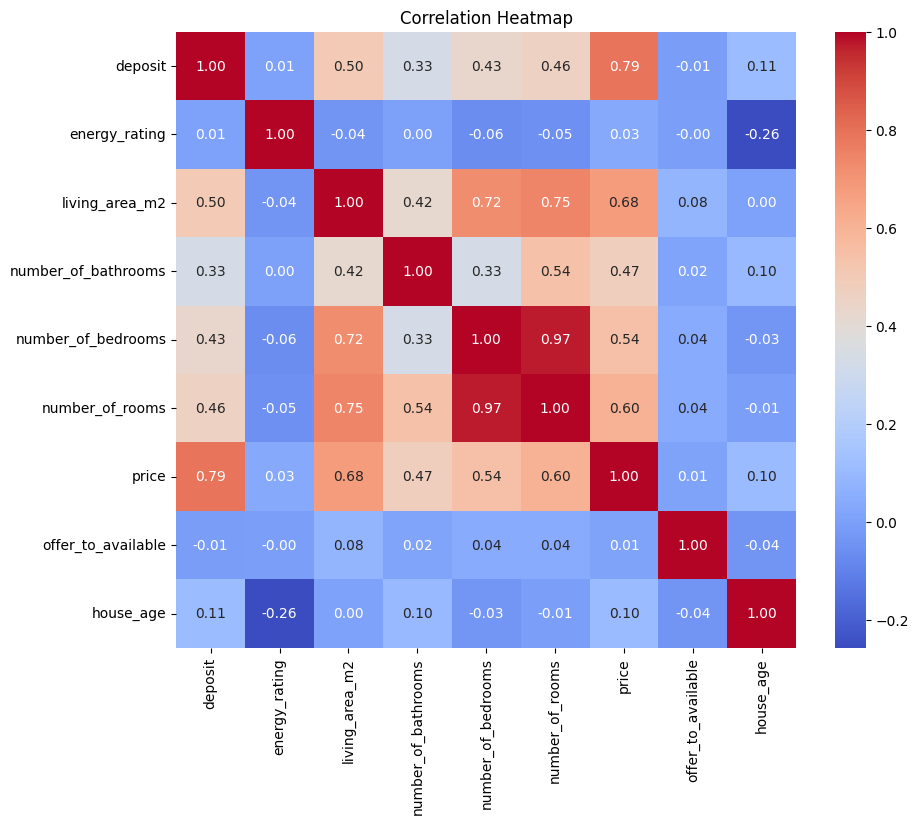

In [15]:

# Filter numerical columns
numerical_features = df.select_dtypes(include=['float64', 'int32'])

# Calculate the correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap")
plt.show()


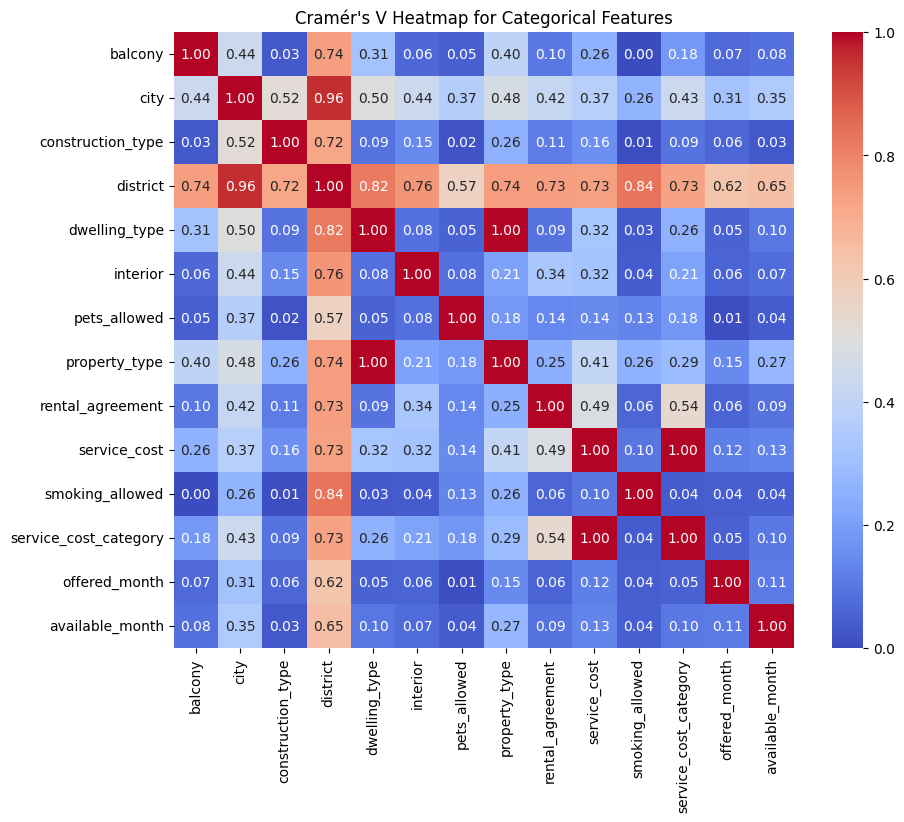

In [16]:
from scipy.stats import chi2_contingency

def cramers_v(contingency_table):
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# Function to calculate Cramér's V matrix
def cramers_v_matrix(df, categorical_features):
    matrix = pd.DataFrame(index=categorical_features, columns=categorical_features)
    for col1 in categorical_features:
        for col2 in categorical_features:
            contingency_table = pd.crosstab(df[col1], df[col2])
            matrix.loc[col1, col2] = cramers_v(contingency_table)
    return matrix.astype(float)

# List of categorical features
categorical_features = ['balcony', 'city', 'construction_type',
       'district', 'dwelling_type', 'interior',
       'pets_allowed', 'property_type', 'rental_agreement', 'service_cost', 'smoking_allowed',
       'service_cost_category', 'offered_month', 'available_month']

# Compute Cramér's V matrix
cramers_v_matrix_df = cramers_v_matrix(df, categorical_features)

# Ensure diagonal elements are 1
np.fill_diagonal(cramers_v_matrix_df.values, 1)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix_df, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Cramér's V Heatmap for Categorical Features")
plt.show()


In [17]:
df = df.drop(columns = ['property_type', 'district', 'service_cost', 'number_of_bedrooms'])

## Reduce dimensionality of data

In [18]:
categorical_features = ['balcony', 'city', 'construction_type', 'dwelling_type', 
                        'interior', 'pets_allowed', 'rental_agreement', 
                        'smoking_allowed','service_cost_category', 'offered_month', 
                        'available_month']

threshold = 0.05 * len(df)  
for col in categorical_features:
    rare_categories = df[col].value_counts()[df[col].value_counts() < threshold].index
    df[col] = df[col].replace(rare_categories, 'Other')

# Statistical Analytics

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   balcony                2201 non-null   object 
 1   city                   2201 non-null   object 
 2   construction_type      2201 non-null   object 
 3   deposit                2201 non-null   float64
 4   dwelling_type          2201 non-null   object 
 5   energy_rating          2201 non-null   Int32  
 6   interior               2201 non-null   object 
 7   living_area_m2         2201 non-null   float64
 8   number_of_bathrooms    2201 non-null   int32  
 9   number_of_rooms        2201 non-null   int32  
 10  pets_allowed           2201 non-null   object 
 11  price                  2201 non-null   float64
 12  rental_agreement       2201 non-null   object 
 13  smoking_allowed        2201 non-null   object 
 14  service_cost_category  2201 non-null   object 
 15  offe

C:\Users\Ying\AppData\Local\Temp\ipykernel_17280\3421047478.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')
C:\Users\Ying\AppData\Local\Temp\ipykernel_17280\3421047478.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data, patch_artist=True, labels=labels)
C:\Users\Ying\AppData\Local\Temp\ipykernel_17280\3421047478.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Set3')
C:\Users\Ying\AppData\Local\Temp\ipykernel_17280\3421047478.py:21: Mat

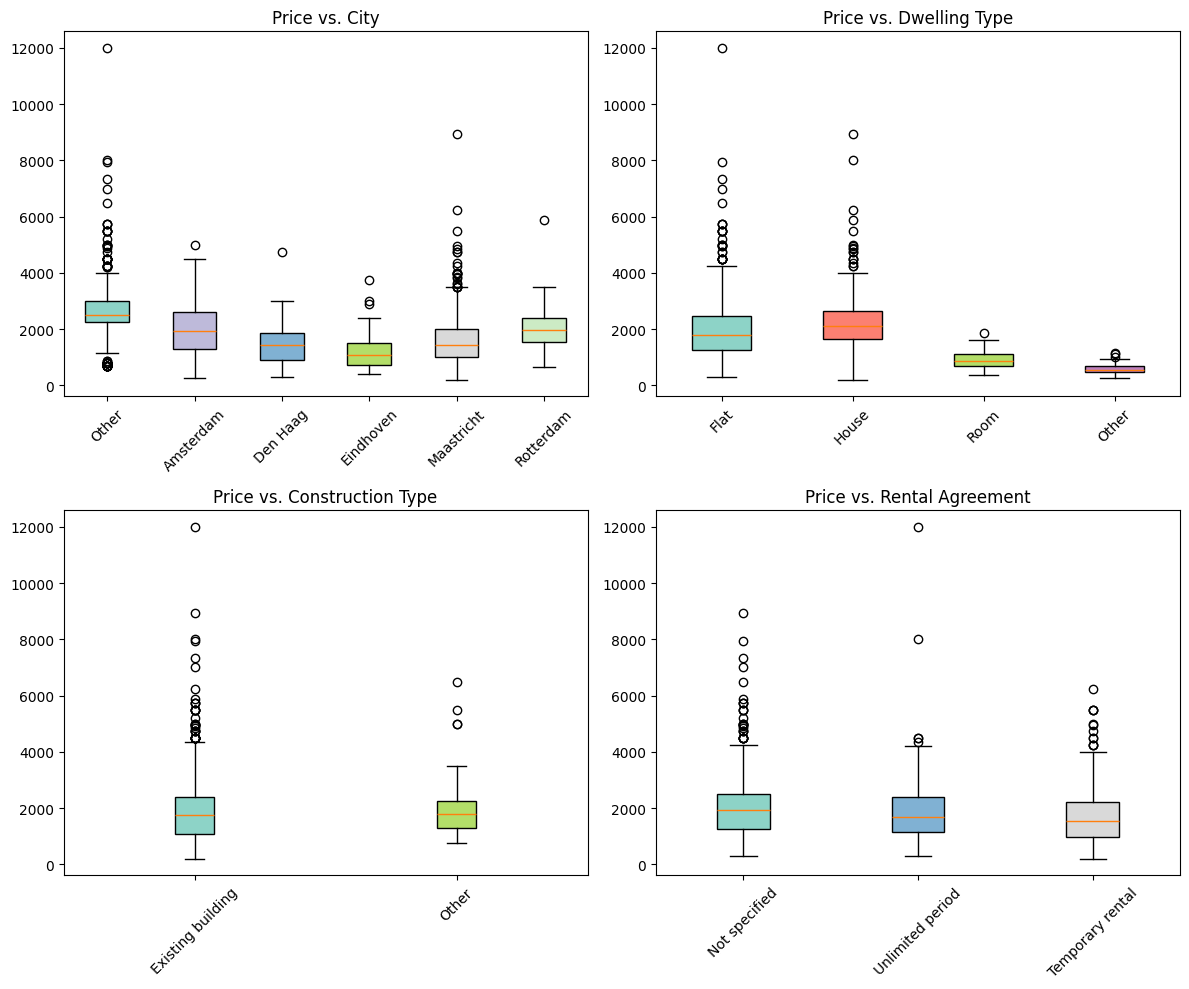

In [ ]:
# Boxplot for price (price vs. city; price vs. dwelling_type; price vs.energy_rating, price vs. construction_type)

# Create price data
price_by_city = [group['price'].values for _, group in df.groupby('city')]
price_by_dwelling = [group['price'].values for _, group in df.groupby('dwelling_type')]
price_by_construction = [group['price'].values for _, group in df.groupby('construction_type')]
price_by_agreement = [group['price'].values for _, group in df.groupby('rental_agreement')]


# Create plots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
def color_boxes(ax, data, labels, title):
    cmap = cm.get_cmap('Set3')
    bp = ax.boxplot(data, patch_artist=True, labels=labels)
    ax.set_title(title)
    ax.tick_params(axis='x', rotation=45)
    # Set individual colors
    for i, patch in enumerate(bp['boxes']):
        patch.set_facecolor(cmap(i / len(bp['boxes'])))

# Plot each boxplot
color_boxes(axs[0, 0], price_by_city, df['city'].unique(), 'Price vs. City')
color_boxes(axs[0, 1], price_by_dwelling, df['dwelling_type'].unique(), 'Price vs. Dwelling Type')
color_boxes(axs[1, 0], price_by_construction, df['construction_type'].unique(), 'Price vs. Construction Type')
color_boxes(axs[1, 1], price_by_agreement, df['rental_agreement'].unique(), 'Price vs. Rental Agreement')

plt.tight_layout()
plt.show()

In [25]:
from scipy.stats import f_oneway

def anova_test(feature):
    groups = [group['price'].values for name, group in df.groupby(feature)]
    f_stat, p_value = f_oneway(*groups)
    print(f"Anova Test for {feature}")
    print("F-statistic:", f_stat)
    print("P-value:", p_value, '\n')


categorical_features = ['city', 'construction_type',
       'dwelling_type', 'rental_agreement']

for f in categorical_features:
    anova_test(f)


Anova Test for city
F-statistic: 144.75475215870418
P-value: 4.989166991249095e-133 

Anova Test for construction_type
F-statistic: 2.4948405315833737
P-value: 0.11436376745065839 

Anova Test for dwelling_type
F-statistic: 178.7196380134117
P-value: 1.1067958830655145e-103 

Anova Test for rental_agreement
F-statistic: 21.86187586043428
P-value: 3.969251800201085e-10 



# One-Hot Encoding

In [19]:
df.columns

Index(['balcony', 'city', 'construction_type', 'deposit', 'dwelling_type',
       'energy_rating', 'interior', 'living_area_m2', 'number_of_bathrooms',
       'number_of_rooms', 'pets_allowed', 'price', 'rental_agreement',
       'smoking_allowed', 'service_cost_category', 'offer_to_available',
       'offered_month', 'available_month', 'house_age'],
      dtype='object')

In [20]:
from sklearn.preprocessing import OneHotEncoder
df = pd.get_dummies(df, columns = ['balcony','city','construction_type', 'dwelling_type', 'interior', 'pets_allowed', 'rental_agreement',
                                   'smoking_allowed', 'service_cost_category', 'offered_month', 'available_month'])
df.head()

,deposit,energy_rating,living_area_m2,number_of_bathrooms,number_of_rooms,price,offer_to_available,house_age,balcony_Not present,balcony_Present,...,service_cost_category_Not included,service_cost_category_Not specified,service_cost_category_Partial included,offered_month_Dec,offered_month_Nov.,offered_month_Other,available_month_Dec,available_month_Feb.,available_month_Jan.,available_month_Other
0,3500.0,6,81.0,1,3,1750.0,21.0,19.0,True,False,...,False,True,False,True,False,False,True,False,False,False
1,3600.0,7,67.0,1,2,1800.0,2.0,14.0,False,True,...,True,False,False,True,False,False,True,False,False,False
2,2000.0,7,54.0,1,2,1100.0,21.0,6.0,True,False,...,False,True,False,True,False,False,True,False,False,False
3,2000.0,3,42.0,1,2,845.0,21.0,45.0,True,False,...,True,False,False,False,True,False,True,False,False,False
4,2000.0,7,40.0,1,2,1200.0,14.0,0.0,True,False,...,False,False,True,False,True,False,True,False,False,False


# Inspect distribution

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 45 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   deposit                                 2201 non-null   float64
 1   energy_rating                           2201 non-null   Int32  
 2   living_area_m2                          2201 non-null   float64
 3   number_of_bathrooms                     2201 non-null   int32  
 4   number_of_rooms                         2201 non-null   int32  
 5   price                                   2201 non-null   float64
 6   offer_to_available                      2201 non-null   float64
 7   house_age                               2201 non-null   float64
 8   balcony_Not present                     2201 non-null   bool   
 9   balcony_Present                         2201 non-null   bool   
 10  city_Amsterdam                          2201 non-null   bool

deposit - min: 4.0, max: 16000.0
energy_rating - min: 1, max: 12
living_area_m2 - min: 7.0, max: 708.0
number_of_bathrooms - min: 1, max: 5
number_of_rooms - min: 2, max: 13
price - min: 200.0, max: 12000.0
offer_to_available - min: 0.0, max: 381.0
house_age - min: -1.0, max: 1019.0


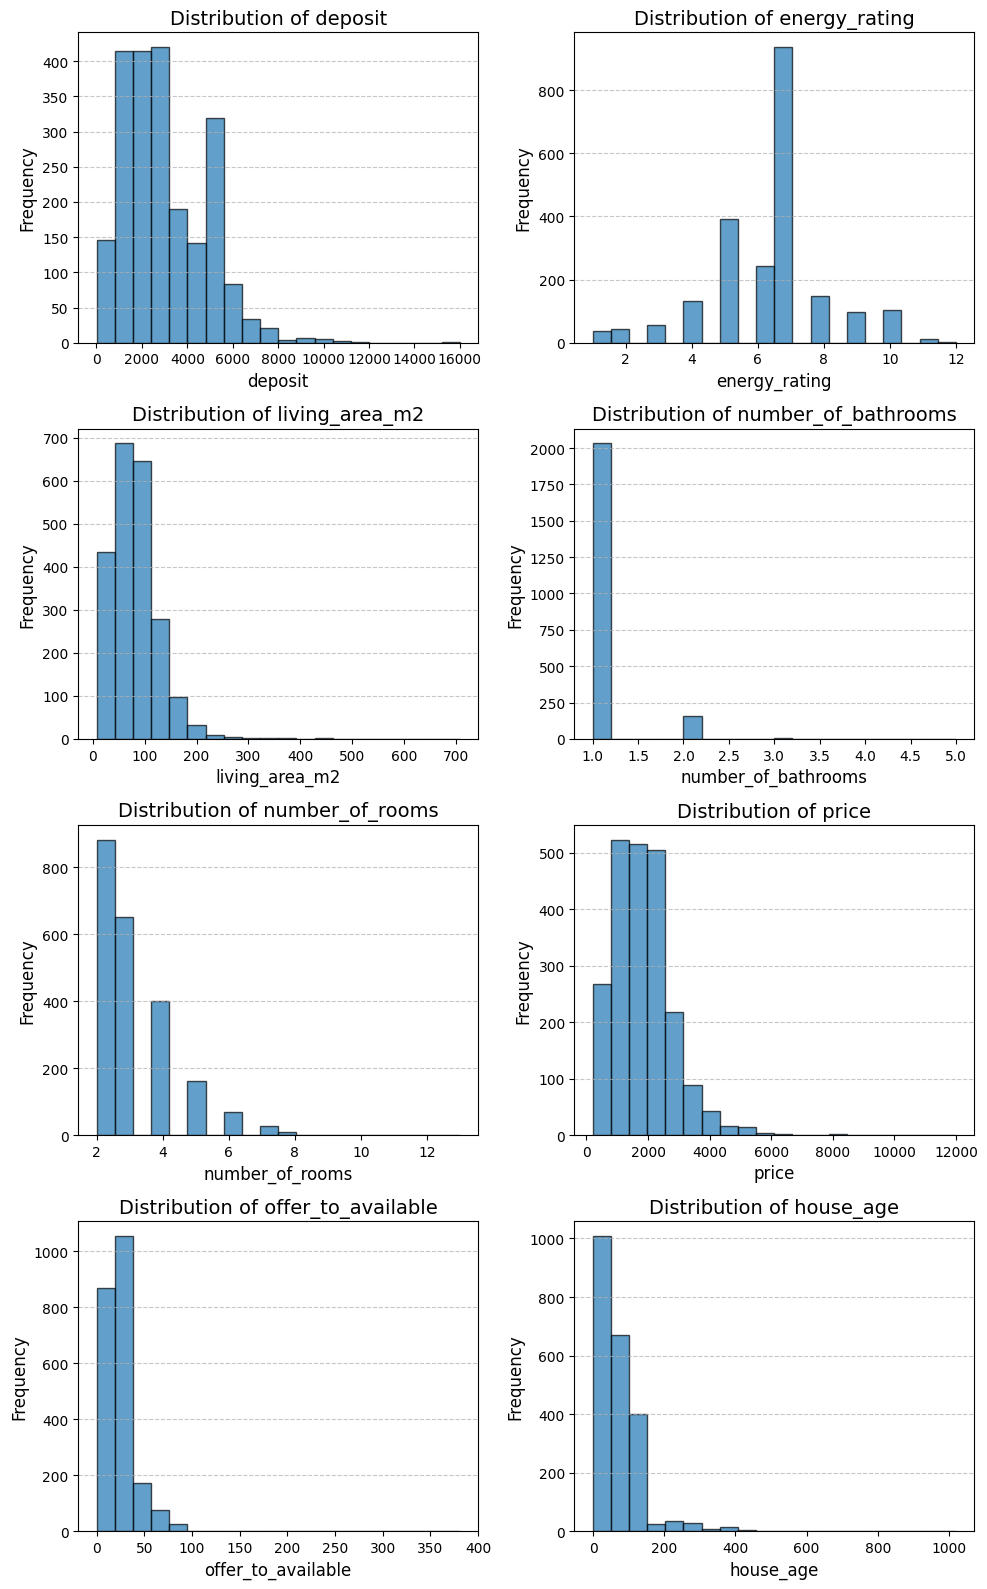

In [22]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int32']).columns

import math
import matplotlib.pyplot as plt

# Calculate the number of rows needed (2 plots per row)
num_cols = 2
num_rows = math.ceil(len(numeric_columns) / num_cols)

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))
# Flatten the axes array for easy iteration
axes = axes.flatten()  

# Loop through numeric columns and plot
for i, column in enumerate(numeric_columns):
    axes[i].hist(df[column].dropna(), bins=20, edgecolor='k', alpha=0.7)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].set_title(f'Distribution of {column}', fontsize=14)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    print(f"{column} - min: {df[column].min()}, max: {df[column].max()}")

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()  # Adjust spacing
plt.show()



In [23]:
df.to_csv('Cleaned Data for ML.csv', index = False)